# Import libraries 

In [ ]:
import sys
from pathlib import Path
sys.path.insert(0,'..')
import glob
import re
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.utils.hdf_tools import load_from_hdf_with_regex
from src.visualisation.visualisation import plot_hdf

# Load mp3 data

In [ ]:
df_mp3_fpa = pd.read_csv("../data/RB_TC_extract_2022_07_07_processed_filled.csv")

# Load data from hdf5

In [ ]:
# define event to laod
fpa_identifier = {'circuit_type': 'RB',
                 'circuit_name': 'RB.A78',
                 'timestamp_fgc': 1616962174400000000}

file_path = Path('/eos/project/m/ml-for-alarm-system/private/RB_signals/20220707_data')
file_name = f"{fpa_identifier['circuit_type']}_{fpa_identifier['circuit_name']}_{fpa_identifier['timestamp_fgc']}.hdf5"
file_dir = file_path / file_name

# define signals to load
signals = ['I_MEAS','VoltageNQPS.*U_DIODE','VoltageNXCALS.*U_DIODE','I_EARTH_PCNT', 'IEARTH.I_EARTH','U_QS0','U_1','U_2','I_HDS', 'U_HDS','EEUDumpResPM']

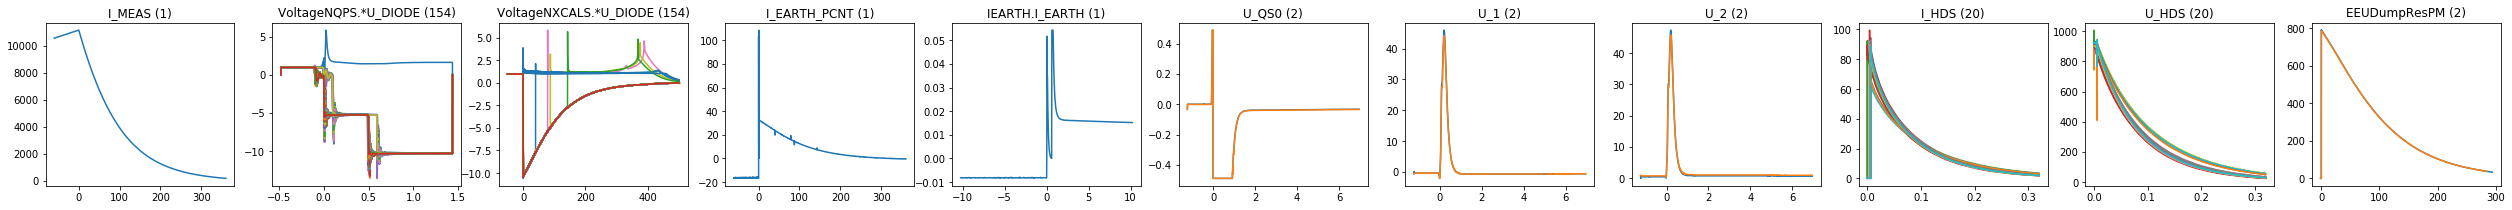

In [4]:
data = load_from_hdf_with_regex(file_dir, regex_list=signals)
plot_hdf(data, column_regex=signals)

# Plot all data

In [ ]:
df_acquisition = pd.read_excel("../data/20220707_acquisition_summary.xlsx")
mp3_fpa_df = pd.read_csv("../data/RB_TC_extract_2022_07_07_processed_filled.csv")

In [ ]:
units = ["A", "V", "V", "%", "A", "V", "V", "V" , "A", "V", "V" , ""]
for j, row in df_acquisition.iterrows():
    
    fig_name = f"{row['date_fgc']}_{row['Circuit Name']}_{j}"
    fig_path = f"/eos/project/m/ml-for-alarm-system/private/RB_signals/20220707_data_visualisation/{fig_name}.png"
    
    if not os.path.isfile(fig_path):
        
        file_name = f"RB_{row['Circuit Name']}_{row['timestamp_fgc']}"
        data = load_from_hdf_with_regex(file_path / (file_name + ".hdf5"), regex_list=signals)
        
        fig, axes = plt.subplots(4, 3, figsize=(4 * 4, 3*5))
        i = 0
        for s, ax in zip(signals, axes.flatten()):
            n_signals = 0
            for df in data:
                if bool(re.search(s, df.columns.values[0])):
                    ax.plot(df.index.values, df.values)
                    n_signals += 1
            ax.set_title(f"{s} ({n_signals})")
            ax.set_xlabel("Time / s")
            ax.set_ylabel(units[i])
            i +=1

        mp3_fpa_df_subset = mp3_fpa_df[(mp3_fpa_df.timestamp_fgc == row['timestamp_fgc']) & (mp3_fpa_df["Circuit Name"] == row['Circuit Name'])]
        quenched_magenets = mp3_fpa_df_subset.Position.values
        quenched_magenets = ''.join(x + " " for x in quenched_magenets)

        fig.delaxes(axes.flatten()[-1])
        fig.tight_layout()
        fig.subplots_adjust(top=0.89)
        title = f"circuit: {row['Circuit Name']} \n date: {row['date_fgc']} \n fgc_timestamp: {row['timestamp_fgc']} \n quenched magnets: {quenched_magenets} "
        fig.suptitle(title)

        plt.savefig(str(fig_path))

        fig.clf()
        plt.clf()
        plt.close(fig)
        del data
        print(f"{j}/{len(df_acquisition)} {file_name}")

# Load acquisition summary

In [ ]:
df_acquisition = pd.read_excel("../data/20220707_acquisition_summary.xlsx")

In [ ]:
(df_acquisition[signals]==1).sum()#.plot.barh()